# Load libraries

In [20]:

from cobra.flux_analysis import flux_variability_analysis
from cobra.io import read_sbml_model
import cobra
import numpy as np
import networkx as nx
from dingo.illustrations import plot_graph
from cobra.flux_analysis.loopless import loopless_solution
import pickle
from dingo import MetabolicNetwork

import matplotlib.pyplot as plt

# Load model, solve with FBA and create duplicate models for modification

In [ ]:
ec_model = read_sbml_model('../../ext_data/models/e_coli_core.xml')
reaction_list = ec_model.reactions

# Solve the model with the default constraints
default_solution = ec_model.optimize()
print(default_solution.objective_value)
print(default_solution.get_primal_by_id("FRD7"))
print(default_solution.get_primal_by_id("SUCDi"))

# Create duplicate models, to later add constraints
ec_model_loopless_fva_FRD7 = ec_model.copy()
ec_model_loopless_fva_FRD7_SUCDi = ec_model.copy()

Set parameter Username
Set parameter LicenseID to value 2642044
Academic license - for non-commercial use only - expires 2026-03-25
0.8739215069684302
0.0
5.064375661482091
Read LP format model from file /tmp/tmpvhhz0t2_.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /tmp/tmplhvjgp15.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /tmp/tmps8qxn09r.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros


# Perform default and loopless FVA

In [4]:

# Define the fraction of the optimum to be used for FVA 
fraction_of_optimum = 1

# Perform default FVA on the model
fva = flux_variability_analysis(ec_model, 
                                loopless=False,
                                fraction_of_optimum=fraction_of_optimum)
fva_dict = fva.apply(lambda row: (row['minimum'], row['maximum']), axis=1).to_dict()

# Perform loopless FVA on the model
fva_loopless = flux_variability_analysis(ec_model, 
                                         loopless=True,
                                         fraction_of_optimum=fraction_of_optimum)
fva_loopless_dict = fva_loopless.apply(lambda row: (row['minimum'], row['maximum']), axis=1).to_dict()


In [ ]:
# See the range of fluxes for the reactions

print(fva_loopless_dict.get("FRD7"))
print(fva_loopless_dict.get("SUCDi"))

(0.0, 0.0)
(5.0643756614819475, 5.064375661482149)


# Modify the duplicate models based on the loopless FVA solution

### Constrain the model to the loopless FVA solution (all reactions)

In [37]:
# define the lower bound for objective function
minimum_objective_value = default_solution.objective_value * 0.7
# Define the number of decimal places to round the bounds to, to avoid errors when setting the bounds in the model
rounding = 10
# Define a tolerance for the bounds. This is to avoid infeasibility due to rounding errors when setting the bounds in the model
tol = 1e-10

### Constrain the model to the loopless FVA solution of FRD7

In [ ]:
# Constrain the model to the loopless solution of FRD7
for reaction in reaction_list:
    if reaction.id == "FRD7":
        model_reaction = ec_model_loopless_fva_FRD7.reactions.get_by_id(reaction.id)
        model_reaction.upper_bound = fva_loopless_dict[reaction.id][1]
        model_reaction.lower_bound = fva_loopless_dict[reaction.id][0]

ec_model_loopless_fva_FRD7.reactions.get_by_id("BIOMASS_Ecoli_core_w_GAM").lower_bound = minimum_objective_value

print("\n\nConstrained model to loopless solution of FRD7")
solution = ec_model_loopless_fva_FRD7.optimize()
print(solution.objective_value)
print("FRD7:", solution.get_primal_by_id("FRD7"))
print("SUCDi:", solution.get_primal_by_id("SUCDi"))




Constrained model to loopless solution of FRD7
0.8739215069684304
FRD7: 0.0
SUCDi: 5.064375661482089


### Constrain the model to loopless FVA solution of FRD7 and SUCDi

In [ ]:
# Constrain the model to the loopless solution of both FRD7 and SUCDi
for reaction in reaction_list:
    if reaction.id == "FRD7" or reaction.id == "SUCDi":
        model_reaction = ec_model_loopless_fva_FRD7_SUCDi.reactions.get_by_id(reaction.id)
        model_reaction.upper_bound = fva_loopless_dict[reaction.id][1]
        model_reaction.lower_bound = fva_loopless_dict[reaction.id][0]

ec_model_loopless_fva_FRD7_SUCDi.reactions.get_by_id("BIOMASS_Ecoli_core_w_GAM").lower_bound = minimum_objective_value

print("\n\nConstrained model to loopless solution of FRD7 and SUCDi")
solution = ec_model_loopless_fva_FRD7_SUCDi.optimize()
print(solution.objective_value)
print("FRD7:", solution.get_primal_by_id("FRD7"))
print("SUCDi:", solution.get_primal_by_id("SUCDi"))



Constrained model to loopless solution of FRD7 and SUCDi
0.8739215069684313
FRD7: 0.0
SUCDi: 5.0643756614819475


### Create the corresponding dingo models

In [40]:
ec_dingo_model = MetabolicNetwork.from_cobra_model(ec_model)
ec_dingo_model_loopless_fva_FRD7 = MetabolicNetwork.from_cobra_model(ec_model_loopless_fva_FRD7)
ec_dingo_model_loopless_fva_FRD7_SUCDi = MetabolicNetwork.from_cobra_model(ec_model_loopless_fva_FRD7_SUCDi)

# Perform sampling on the default and modified models

### Sampling with OptGP

In [41]:
# Completed in 70% opt.
# Completed in 100% opt.
sampler_ec_model = cobra.sampling.optgp.OptGPSampler(ec_model)
samples_ec_model = sampler_ec_model.sample(n=1000)
samples_ec_model = samples_ec_model.to_numpy().T


# Completed in 70% opt.
# ValueError: Flux cone only consists a single point. in 100% opt
sampler_ec_model_loopless_fva_FRD7 = cobra.sampling.optgp.OptGPSampler(ec_model_loopless_fva_FRD7)
samples_ec_model_loopless_fva_FRD7 = sampler_ec_model_loopless_fva_FRD7.sample(n=1000)
samples_ec_model_loopless_fva_FRD7 = samples_ec_model_loopless_fva_FRD7.to_numpy().T


# Completed in 70% opt.
# ValueError: Flux cone only consists a single point. in 100% opt
sampler_ec_model_loopless_fva_FRD7_SUCDi = cobra.sampling.optgp.OptGPSampler(ec_model_loopless_fva_FRD7_SUCDi)
samples_ec_model_loopless_fva_FRD7_SUCDi = sampler_ec_model_loopless_fva_FRD7_SUCDi.sample(n=1000)
samples_ec_model_loopless_fva_FRD7_SUCDi = samples_ec_model_loopless_fva_FRD7_SUCDi.to_numpy().T


Read LP format model from file /tmp/tmpyt50balk.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /tmp/tmp29ut7w7_.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /tmp/tmpapd6o4m_.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros


### Sampling with dingo

In [42]:

"""
# Completed but almost fixed biomass and CO2
with open('../../ext_data/dingo_samples/samples_dingo_ec_default_opt_100.pckl', 'rb') as f:
    samples_dingo_ec_default = pickle.load(f)

# Completed but almost fixed biomass and CO2
with open('../../ext_data/dingo_samples/samples_dingo_ec_loopless_FRD7_opt_100.pckl', 'rb') as f:
    samples_dingo_ec_loopless_FRD7 = pickle.load(f)

# Completed but almost fixed biomass and CO2
with open('../../ext_data/dingo_samples/samples_dingo_ec_loopless_FRD7_SUCDi_opt_100.pckl', 'rb') as f:
    samples_dingo_ec_loopless_FRD7_SUCDi = pickle.load(f)
"""

# -------------------------------------------------    

# Completed but almost fixed biomass and CO2
with open('../../ext_data/dingo_samples/samples_dingo_ec_default_opt_70.pckl', 'rb') as f:
    samples_dingo_ec_default = pickle.load(f)

# Completed but almost fixed biomass and CO2
with open('../../ext_data/dingo_samples/samples_dingo_ec_loopless_FRD7_opt_70.pckl', 'rb') as f:
    samples_dingo_ec_loopless_FRD7 = pickle.load(f)

# Completed but almost fixed biomass and CO2
with open('../../ext_data/dingo_samples/samples_dingo_ec_loopless_FRD7_SUCDi_opt_70.pckl', 'rb') as f:
    samples_dingo_ec_loopless_FRD7_SUCDi = pickle.load(f)


# Calculate statistics from samples

### From OptGP samples

In [43]:
FRD7_index = reaction_list.index("FRD7")
SUCDi_index = reaction_list.index("SUCDi")

# Print statistics for the samples of FRD7 across the different constained models
print("Mean value from samples of FRD7 across the different models")
print("Mean of FRD7 from non-constrained model:", np.mean(samples_ec_model[FRD7_index]))
print("Mean of FRD7 from FRD7 and SUCDi constrained model", np.mean(samples_ec_model_loopless_fva_FRD7[FRD7_index]))
print("Mean of FRD7 from FRD7 and SUCDi constrained model:", np.mean(samples_ec_model_loopless_fva_FRD7_SUCDi[FRD7_index]))

print("\nRange values from samples of FRD7 across the different models")
print("Range values of FRD7 from non-constrained model:", np.min(samples_ec_model[FRD7_index]), 
                                                          np.max(samples_ec_model[FRD7_index]))
print("Range values of FRD7 from FRD7 and SUCDi constrained model", np.min(samples_ec_model_loopless_fva_FRD7[FRD7_index]),
                                                                    np.max(samples_ec_model_loopless_fva_FRD7[FRD7_index]))
print("Range values of FRD7 from FRD7 and SUCDi constrained model:", np.min(samples_ec_model_loopless_fva_FRD7_SUCDi[FRD7_index]),
                                                                     np.max(samples_ec_model_loopless_fva_FRD7_SUCDi[FRD7_index]))


# Print statistics for the samples of SUCDi across the different constained models
print("\nMean value from samples of SUCDi across the different models")
print("Mean of SUCDi from non-constrained model:", np.mean(samples_ec_model[SUCDi_index]))
print("Mean of SUCDi from FRD7 constrained model", np.mean(samples_ec_model_loopless_fva_FRD7[SUCDi_index]))
print("Mean of SUCDi from FRD7 and SUCDi constrained model",np.mean(samples_ec_model_loopless_fva_FRD7_SUCDi[SUCDi_index]))

print("\nRange values from samples of SUCDi across the different models")
print("Range values of SUCDi from non-constrained model:", np.min(samples_ec_model[SUCDi_index]), 
                                                           np.max(samples_ec_model[SUCDi_index]))
print("Range values of SUCDi from FRD7 and SUCDi constrained model", np.min(samples_ec_model_loopless_fva_FRD7[SUCDi_index]),
                                                                     np.max(samples_ec_model_loopless_fva_FRD7[SUCDi_index]))
print("Range values of SUCDi from FRD7 and SUCDi constrained model:", np.min(samples_ec_model_loopless_fva_FRD7_SUCDi[SUCDi_index]),
                                                                      np.max(samples_ec_model_loopless_fva_FRD7_SUCDi[SUCDi_index]))

Mean value from samples of FRD7 across the different models
Mean of FRD7 from non-constrained model: 485.9828805083871
Mean of FRD7 from FRD7 and SUCDi constrained model 0.0
Mean of FRD7 from FRD7 and SUCDi constrained model: 0.0

Range values from samples of FRD7 across the different models
Range values of FRD7 from non-constrained model: 0.6805537469243275 995.276114699193
Range values of FRD7 from FRD7 and SUCDi constrained model 0.0 0.0
Range values of FRD7 from FRD7 and SUCDi constrained model: 0.0 0.0

Mean value from samples of SUCDi across the different models
Mean of SUCDi from non-constrained model: 492.92591890484556
Mean of SUCDi from FRD7 constrained model 5.829554250178677
Mean of SUCDi from FRD7 and SUCDi constrained model 5.0643756614821465

Range values from samples of SUCDi across the different models
Range values of SUCDi from non-constrained model: 4.246105272803005 999.9117739377015
Range values of SUCDi from FRD7 and SUCDi constrained model 0.1992112578198574 8.84

### From dingo samples

In [44]:
FRD7_index = reaction_list.index("FRD7")
SUCDi_index = reaction_list.index("SUCDi")

# Print statistics for the samples of FRD7 across the different constained models
print("Mean value from samples of FRD7 across the different models")
print("Mean of FRD7 from non-constrained model:", np.mean(samples_dingo_ec_default[FRD7_index]))
print("Mean of FRD7 from FRD7 and SUCDi constrained model", np.mean(samples_dingo_ec_loopless_FRD7[FRD7_index]))
print("Mean of FRD7 from FRD7 and SUCDi constrained model:", np.mean(samples_dingo_ec_loopless_FRD7_SUCDi[FRD7_index]))

print("\nRange values from samples of FRD7 across the different models")
print("Range values of FRD7 from non-constrained model:", np.min(samples_dingo_ec_default[FRD7_index]), 
                                                          np.max(samples_dingo_ec_default[FRD7_index]))
print("Range values of FRD7 from FRD7 and SUCDi constrained model", np.min(samples_dingo_ec_loopless_FRD7[FRD7_index]),
                                                                    np.max(samples_dingo_ec_loopless_FRD7[FRD7_index]))
print("Range values of FRD7 from FRD7 and SUCDi constrained model:", np.min(samples_dingo_ec_loopless_FRD7_SUCDi[FRD7_index]),
                                                                     np.max(samples_dingo_ec_loopless_FRD7_SUCDi[FRD7_index]))


# Print statistics for the samples of SUCDi across the different constained models
print("\nMean value from samples of SUCDi across the different models")
print("Mean of SUCDi from non-constrained model:", np.mean(samples_dingo_ec_default[SUCDi_index]))
print("Mean of SUCDi from FRD7 constrained model", np.mean(samples_dingo_ec_loopless_FRD7[SUCDi_index]))
print("Mean of SUCDi from FRD7 and SUCDi constrained model",np.mean(samples_dingo_ec_loopless_FRD7_SUCDi[SUCDi_index]))

print("\nRange values from samples of SUCDi across the different models")
print("Range values of SUCDi from non-constrained model:", np.min(samples_dingo_ec_default[SUCDi_index]), 
                                                           np.max(samples_dingo_ec_default[SUCDi_index]))
print("Range values of SUCDi from FRD7 and SUCDi constrained model", np.min(samples_dingo_ec_loopless_FRD7[SUCDi_index]),
                                                                     np.max(samples_dingo_ec_loopless_FRD7[SUCDi_index]))
print("Range values of SUCDi from FRD7 and SUCDi constrained model:", np.min(samples_dingo_ec_loopless_FRD7_SUCDi[SUCDi_index]),
                                                                      np.max(samples_dingo_ec_loopless_FRD7_SUCDi[SUCDi_index]))

Mean value from samples of FRD7 across the different models
Mean of FRD7 from non-constrained model: 441.44563051098885
Mean of FRD7 from FRD7 and SUCDi constrained model 0.0
Mean of FRD7 from FRD7 and SUCDi constrained model: 7.077671781985373e-16

Range values from samples of FRD7 across the different models
Range values of FRD7 from non-constrained model: 0.38111009842346705 995.8510045915147
Range values of FRD7 from FRD7 and SUCDi constrained model 0.0 0.0
Range values of FRD7 from FRD7 and SUCDi constrained model: 7.077671781985373e-16 7.077671781985373e-16

Mean value from samples of SUCDi across the different models
Mean of SUCDi from non-constrained model: 447.47964961841325
Mean of SUCDi from FRD7 constrained model 5.938910227408134
Mean of SUCDi from FRD7 and SUCDi constrained model 5.064376000000003

Range values from samples of SUCDi across the different models
Range values of SUCDi from non-constrained model: 4.923803547705862 999.7757768395186
Range values of SUCDi from 

# Calculate the FBA loopless solution

In [70]:
cobra_reactions_str = [str(reaction.id) for reaction in reaction_list]

loopless_solutions = []

# cobra
for sol in samples_ec_model.T:
#for sol in samples_ec_model_loopless_fva_FRD7.T:
#for sol in samples_ec_model_loopless_fva_FRD7_SUCDi.T:

# dingo
#for sol in samples_dingo_ec_default.T:
#for sol in samples_dingo_ec_loopless_FRD7.T:
#for sol in samples_dingo_ec_loopless_fva_FRD7_SUCDi.T:
    
    fluxes = {k:v for k,v in zip(cobra_reactions_str, sol)}
    
    # cobra
    loopless_sol = loopless_solution(model=ec_model, fluxes=fluxes)
    #loopless_sol = loopless_solution(model=ec_model_loopless_fva_FRD7, fluxes=fluxes)
    #loopless_sol = loopless_solution(model=ec_model_loopless_fva_FRD7_SUCDi, fluxes=fluxes)
    
    loopless_solutions.append(loopless_sol)


/home/touliopoulos/.local/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


### Find which samples have significant differences

### Plot histograms of the samples before and after loopless solutions

Histogram from BIOMASS_Ecoli_core_w_GAM samples


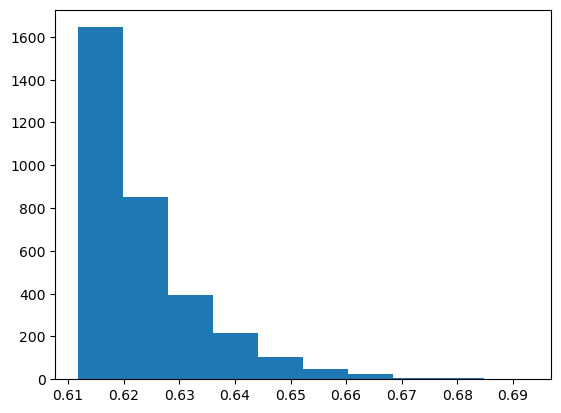

Histogram from BIOMASS_Ecoli_core_w_GAM samples after loopless solution


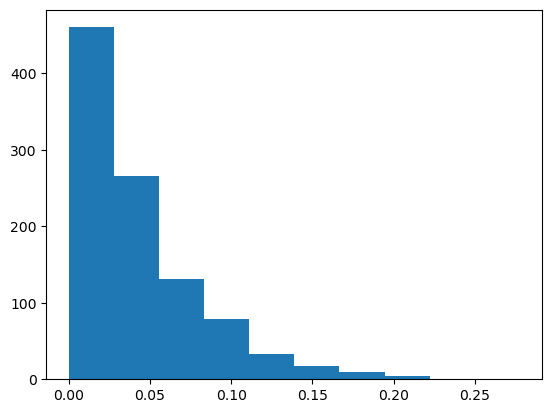

Histogram from CO2 samples


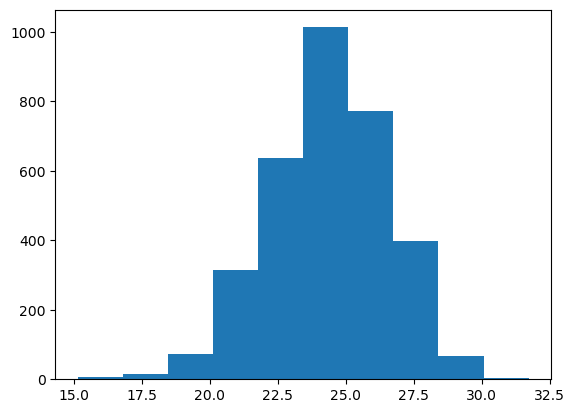

Histogram from CO2 samples after loopless solution


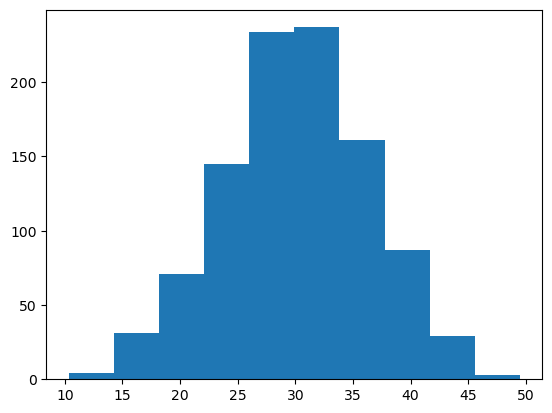

Histogram from SUCDi samples


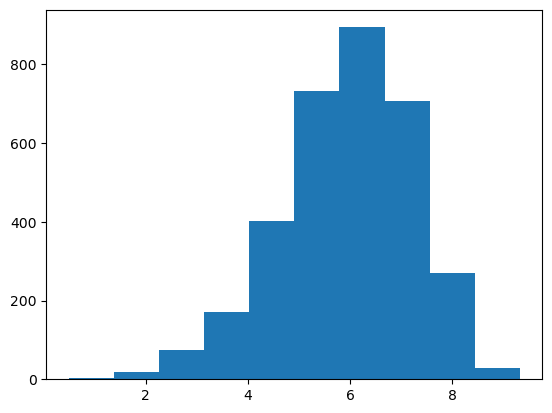

Histogram from SUCDi samples after loopless solution


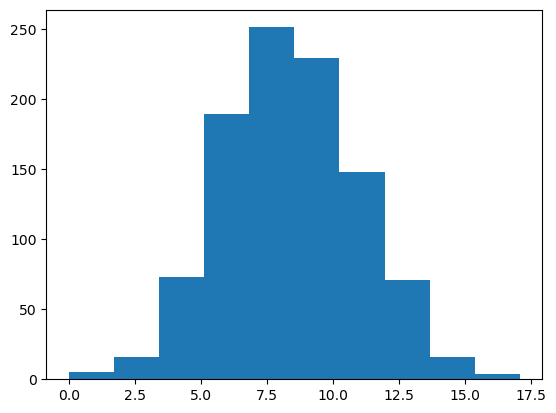

Histogram from FRD7 samples


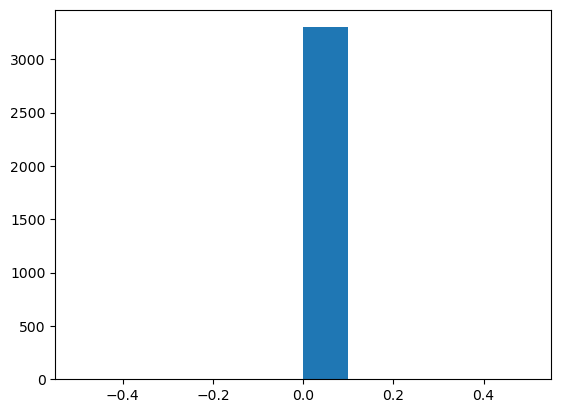

Histogram from FRD7 samples after loopless solution


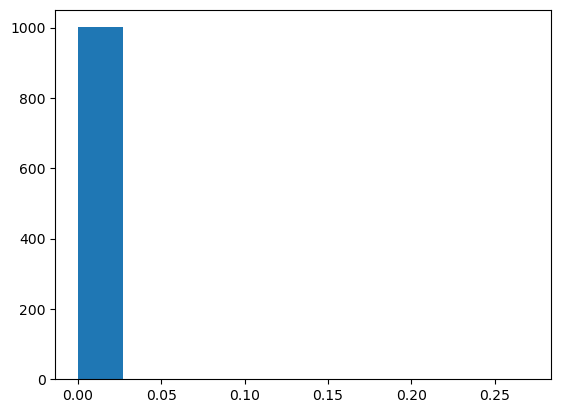

In [ ]:
biomass_index = cobra_reactions_str.index("BIOMASS_Ecoli_core_w_GAM")

print("Histogram from BIOMASS_Ecoli_core_w_GAM samples")
plt.hist(samples_dingo_ec_loopless_FRD7[biomass_index])
plt.show()


loopless_obj = []
for sol in loopless_solutions:
    loopless_obj.append(sol.objective_value)

print("Histogram from BIOMASS_Ecoli_core_w_GAM samples after loopless solution")
plt.hist(loopless_obj)
plt.show()


# -------------------------


print("Histogram from CO2 samples")
CO2_index = cobra_reactions_str.index("EX_co2_e")


plt.hist(samples_dingo_ec_loopless_FRD7[CO2_index])
plt.show()


co2_fluxes = []
for sol in loopless_solutions:
   
    co2_fluxes.append(sol.to_frame()["fluxes"]["EX_co2_e"])

print("Histogram from CO2 samples after loopless solution")
plt.hist(co2_fluxes)
plt.show()


# -------------------------


SUCDi_index = cobra_reactions_str.index("SUCDi")

print("Histogram from SUCDi samples")
plt.hist(samples_dingo_ec_loopless_FRD7[SUCDi_index])
plt.show()


SUCDi_fluxes = []
for sol in loopless_solutions:
   
    SUCDi_fluxes.append(sol.to_frame()["fluxes"]["SUCDi"])

print("Histogram from SUCDi samples after loopless solution")
plt.hist(SUCDi_fluxes)
plt.show()


# -------------------------


FRD7_index = cobra_reactions_str.index("FRD7")

print("Histogram from FRD7 samples")
plt.hist(samples_dingo_ec_loopless_FRD7[FRD7_index])
plt.show()


FRD7_fluxes = []
for sol in loopless_solutions:
   
    FRD7_fluxes.append(sol.to_frame()["fluxes"]["FRD7"])

print("Histogram from FRD7 samples after loopless solution")
plt.hist(FRD7_fluxes)
plt.show()

# Visualize network with graphs

In [14]:

correlation_matrix_ec_model = np.corrcoef(samples_ec_model)
correlation_matrix_ec_model[np.isnan(correlation_matrix_ec_model)] = 0
print(correlation_matrix_ec_model.shape)


correlation_matrix_ec_model_loopless_fva_FRD7 = np.corrcoef(samples_ec_model_loopless_fva_FRD7)
correlation_matrix_ec_model_loopless_fva_FRD7[np.isnan(correlation_matrix_ec_model_loopless_fva_FRD7)] = 0
print(correlation_matrix_ec_model_loopless_fva_FRD7.shape)


correlation_matrix_ec_model_loopless_fva_FRD7_SUCDi = np.corrcoef(samples_ec_model_loopless_fva_FRD7_SUCDi)
correlation_matrix_ec_model_loopless_fva_FRD7_SUCDi[np.isnan(correlation_matrix_ec_model_loopless_fva_FRD7_SUCDi)] = 0
print(correlation_matrix_ec_model_loopless_fva_FRD7_SUCDi.shape)



def graphs(correlation_matrix, reactions, correction=True):
       
    graph_matrix = correlation_matrix.copy()
    np.fill_diagonal(graph_matrix, 0)
    
    if correction == True:
        graph_matrix = abs(graph_matrix)
        
    G = nx.from_numpy_array(graph_matrix)
    G = nx.relabel_nodes(G, lambda x: reactions[x])
    
    pos = nx.spring_layout(G)
    unconnected_nodes = list(nx.isolates(G))
    G.remove_nodes_from(unconnected_nodes)
    
    center_x = np.mean([p[0] for p in pos.values()])
    center_y = np.mean([p[1] for p in pos.values()])
    central_nodes = [node for node, (x, y) in pos.items() if abs(x - center_x) < 0.2 and abs(y - center_y) < 0.2]
    
    return G, pos, central_nodes
    


cobra_reactions_str = [str(reaction.id) for reaction in reaction_list]



G_ec_model, layout_ec_model, central_nodes_ec_model  = graphs(correlation_matrix_ec_model,
                reactions = cobra_reactions_str,
                correction=True
                )
plot_graph(G_ec_model, layout_ec_model)



G_ec_model_loopless_fva_FRD7, layout_ec_mode_loopless_fva_FRD7, central_nodes_ec_model_loopless_fva_FRD7  = graphs(correlation_matrix_ec_model_loopless_fva_FRD7,
                reactions = cobra_reactions_str,
                correction=True
                )
plot_graph(G_ec_model_loopless_fva_FRD7, layout_ec_mode_loopless_fva_FRD7)



G_ec_model_loopless_fva_FRD7_SUCDi, layout_ec_mode_loopless_fva_FRD7_SUCDi, central_nodes_ec_model_loopless_fva_FRD7_SUCDi  = graphs(correlation_matrix_ec_model_loopless_fva_FRD7_SUCDi,
                reactions = cobra_reactions_str,
                correction=True
                )
plot_graph(G_ec_model_loopless_fva_FRD7_SUCDi, layout_ec_mode_loopless_fva_FRD7_SUCDi)




/home/touliopoulos/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/touliopoulos/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


(95, 95)
(95, 95)
(95, 95)
